# e-commerce project

> В проекте необходимо ответить на следующие вопросы: 
1. Cколько у нас пользователей, которые совершили покупку только один раз?
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
3. По каждому товару определить, в какой день недели товар чаще всего покупается.
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
5. Выполнить когортный анализ пользователей.В период с января по декабрь выявить когорту с самым высоким retention на 3-й месяц.
6. Построить RFM-сегментацию пользователей.

**для начала импортируем все необходимые библиотеки:**

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time
from IPython.display import display

**читаем файлы, используемые для анализа:**

In [159]:
orders_data = pd.read_csv('olist_orders_dataset.csv')
items_data = pd.read_csv('olist_order_items_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')

**для дальнейшей работы переводим все поля с датами в формат datetime:**

In [81]:
orders_data.order_purchase_timestamp = pd.to_datetime(orders_data.order_purchase_timestamp)
orders_data.order_approved_at = pd.to_datetime(orders_data.order_approved_at)
orders_data.order_delivered_carrier_date = pd.to_datetime(orders_data.order_delivered_carrier_date)
orders_data.order_delivered_customer_date = pd.to_datetime(orders_data.order_delivered_customer_date)
orders_data.order_estimated_delivery_date = pd.to_datetime(orders_data.order_estimated_delivery_date)
items_data.shipping_limit_date = pd.to_datetime(items_data.shipping_limit_date)

## Определяем число пользователей, совершивших покупку только 1 раз

**для этого необходимо объединить два датасета - информацию по заказам и покупателям. Это нужно для того, чтобы считать число покупателей по их уникальному id**

In [82]:
orders_data = pd.merge(orders_data, customers, how = 'outer', on ='customer_id')
orders_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


# сколько пользователей совершили покупку только 1 раз 

**Перед вычислением покупок проверим, какое количество отмененных заказов приходится на 1 пользователя:**

In [83]:
orders_data.query('order_status=="canceled"').groupby('customer_unique_id').order_id.count().sort_values().reset_index()\
            .rename(columns = {'order_id':'canceled_orders_num','customer_unique_id':'customer'}).describe()

,canceled_orders_num
count,616.000000
mean,1.014610
std,0.132937
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


> **как видно из описательной статистики, в среднем у пользователей 1 отмененный заказ. Максимальное число отмененных заказов составило 3, поэтому можно сделать вывод, что сбоев в системе и массовых отмен не было. Можно проводить аналитику дальше.**

**Посмотрим, как выглядит структура отмененных заказов:**

In [84]:
orders_data.query('order_status=="canceled"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 397 to 99347
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       625 non-null    object        
 1   customer_id                    625 non-null    object        
 2   order_status                   625 non-null    object        
 3   order_purchase_timestamp       625 non-null    datetime64[ns]
 4   order_approved_at              484 non-null    datetime64[ns]
 5   order_delivered_carrier_date   75 non-null     datetime64[ns]
 6   order_delivered_customer_date  6 non-null      datetime64[ns]
 7   order_estimated_delivery_date  625 non-null    datetime64[ns]
 8   customer_unique_id             625 non-null    object        
 9   customer_zip_code_prefix       625 non-null    int64         
 10  customer_city                  625 non-null    object        
 11  customer_state 

> **мы видим, что из 625 отмененных заказов у 484 есть оплата (order_approved_at), а 6 из них были доставлены (order_delivered_customer_date). Это говорит нам о том, что даже несмотря на факт оплаты и доставки заказа, клиент может вернуть/отменить его. Поэтому в качестве "совершенной" покупки будем считать только заказы со статусом delivered и unavailable (считаем такие заказы "совершенной покупкой", т.к. заказ не выкупили не из-за покупателя, а по причине его отсутствия у продавца)**

**далее для упрощения работы создадим таблицу только с совершенными покупками:**

In [85]:
orders_data_puschases = orders_data.query('order_status in ["delivered","unavailable"]')

**считаем количество уникальных покупателей за весь период (совершивших покупку):**

In [86]:
print(f"Число уникальных покупателей, совершивших покупку, составило {orders_data_puschases.customer_unique_id.nunique()}")

Число уникальных покупателей, совершивших покупку, составило 93929


**считаем количество уникальных покупателей за весь период, совершивших только 1 покупку**

In [87]:
uniq_customers_with_1_sale = orders_data_puschases.groupby('customer_unique_id').order_id.count().sort_values().reset_index()\
            .query('order_id==1').customer_unique_id.nunique()
print(f"Число уникальных покупателей, совершивших только 1 покупку, составило {uniq_customers_with_1_sale}")

Число уникальных покупателей, совершивших только 1 покупку, составило 91093


**из этого следует, что почти все клиенты магазина (97%) совершили покупку только 1 раз:**

In [88]:
print(f"{round(((uniq_customers_with_1_sale/93929)*100),1)} % клиентов совершили покупку только 1 раз ")

97.0 % клиентов совершили покупку только 1 раз 


## Вычисляем причины, по которым товары не доставляются в среднем по месяцу

**для изучения месяцев создаем доп.столбец "месяц_год"**\
*p.s. здесь за месяц, в который заказ не доставили по какой-либо прочине, считаем месяц обещанной даты доставки*

In [89]:
orders_data['planned_delivery_month_year'] = orders_data["order_estimated_delivery_date"].dt.month_name() + "-" + \
                                            orders_data["order_estimated_delivery_date"].dt.year.astype(str)

**выбираем заказы со всеми статусами, кроме delivered, и считаем число заказов с каждым статусом в каждом месяце, затем смотрим среднее число заказов с каждым статусом в месяц**

In [90]:
orders_data.query('order_status !="delivered"').groupby(['order_status', 'planned_delivery_month_year'])\
                            .order_id.nunique().reset_index()\
                            .groupby(['order_status']).mean()\
                            .rename(columns ={'order_id':'avg_orders_num'})\
                            .sort_values(by='avg_orders_num', ascending = False)

,avg_orders_num
order_status,
shipped,48.130435
unavailable,29.000000
canceled,24.038462
processing,15.842105
invoiced,14.952381
created,1.666667
approved,1.000000


> **таким образом мы видим, что наиболее частая причина того, что товар не доставили в обещанную дату, нахождение в пути (задержки логистики). Вторая наиболее частая причина - недоступность товара у продавца. Отмена товара является третьей наиболее частой причиной.**

## Изучаем, в какие дни товары продаются наиболее часто

**для изучения продажи продуктов по дням недели создаем доп.столбец "день недели". В данной задаче в качестве фокусной даты берем дату создания заказа, т.к.необходимо отследить дни, когда товары именно выбирались покупателями (а это дата создания заказа)**

In [91]:
orders_data_puschases['order_creation_weekday'] = orders_data.order_purchase_timestamp.dt.day_name()
orders_data_puschases.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_creation_weekday
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,Tuesday


**для изучения продажи продуктов необходимо смерджить основную таблицу с заказами с таблицей по продуктам**

In [92]:
orders_detailed = pd.merge(orders_data_puschases, items_data, on = 'order_id')

**создаем таблицу по продуктам и дням недели с подсчетом числа заказов**

In [93]:
items_by_weekday = orders_detailed.groupby(['product_id','order_creation_weekday'], as_index=False)\
                .order_id.count()\
                .sort_values(by=['product_id','order_id'], ascending = False)\
                .rename(columns={'order_id':'orders_count'})
items_by_weekday.head()

,product_id,order_creation_weekday,orders_count
59959,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1
59958,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
59955,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
59956,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
59957,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1


**для каждого продукта выбираем из полученного датасета день с максимальным числом заказов (день, в который продукт чаще всего продается)**

In [94]:
max_weekday = items_by_weekday.groupby('product_id').first().sort_values(by='orders_count', ascending = False)
max_weekday.head()

,order_creation_weekday,orders_count
product_id,,
422879e10f46682990de24d770e7f83d,Wednesday,93
99a4788cb24856965c36a24e339b6058,Monday,91
aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
368c6c730842d78016ad823897a372db,Friday,67


**видим, что самыми популярными днями являются Понедельник и Пятница:**

<AxesSubplot:ylabel='order_creation_weekday'>

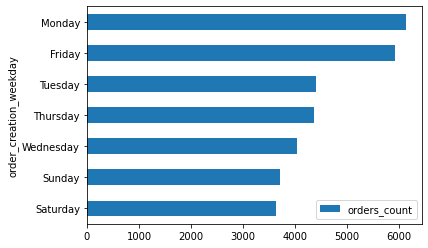

In [95]:
max_weekday.groupby('order_creation_weekday').count().sort_values(by='orders_count', ascending = True).plot(kind="barh")

 ## Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)

 **Создаем несколько вспомогательных столбцов. Здесь ориентируемся на дату подтверждения оплаты,так как именно она является фактом покупки со стороны покупателя**

In [96]:
# число дней в месяце оплаты заказа
orders_data_puschases['paydate_days_in_month'] = orders_data_puschases.order_approved_at.dt.days_in_month

# число недель в месяце оплаты заказа
orders_data_puschases['paydate_weeks_in_month'] = orders_data_puschases.paydate_days_in_month/7.0

# месяц оплаты заказа
orders_data_puschases['paydate_month'] = orders_data_puschases.order_approved_at.dt.month_name()
orders_data_puschases.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_creation_weekday,paydate_days_in_month,paydate_weeks_in_month,paydate_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Monday,31.0,4.428571,October
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,Tuesday,31.0,4.428571,July
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,Wednesday,31.0,4.428571,August
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,Saturday,30.0,4.285714,November
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,Tuesday,28.0,4.000000,February


**создаем таблицу с информацией в связке клиент-месяц: смотрим число недель и заказов в месяце**

In [97]:
data_by_customer = orders_data_puschases.groupby(['customer_unique_id','paydate_month','paydate_weeks_in_month']).order_id.nunique().reset_index()\
                    .rename(columns={'order_id':'orders_count_per_month'})
data_by_customer.head()

,customer_unique_id,paydate_month,paydate_weeks_in_month,orders_count_per_month
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.428571,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.428571,1
2,0000f46a3911fa3c0805444483337064,March,4.428571,1
3,0000f6ccb0745a6a4b88665a16c9f078,October,4.428571,1
4,0004aac84e0df4da2b147fca70cf8255,November,4.285714,1


**расчитываем число заказов в неделю (по месяцам) для каждого клиента**

In [98]:
data_by_customer['orders_per_week'] = data_by_customer.orders_count_per_month / data_by_customer.paydate_weeks_in_month

**группируем данные только по клиентам, чтобы посмотреть среднее число покупок в неделю для каждого пользователя (без привязки к месяцу)** 

In [99]:
data_by_customer.groupby('customer_unique_id').orders_per_week.mean().round(1).reset_index().rename(columns={'orders_per_week':'avg_orders_per_week'})

,customer_unique_id,avg_orders_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,0.2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.2
2,0000f46a3911fa3c0805444483337064,0.2
3,0000f6ccb0745a6a4b88665a16c9f078,0.2
4,0004aac84e0df4da2b147fca70cf8255,0.2
...,...,...
93911,fffcf5a5ff07b0908bd4e2dbc735a684,0.2
93912,fffea47cd6d3cc0a88bd621562a9d061,0.2
93913,ffff371b4d645b6ecea244b27531430a,0.2
93914,ffff5962728ec6157033ef9805bacc48,0.2


> **исходя из результатов, пользователи редко делают заказы, т.к. медианное число заказов в неделю составило 0.2. Выше мы выявили, что 97% клиентов не совершали повторных покупок, что влияет на текущие результаты.**

In [100]:
data_by_customer.groupby('customer_unique_id').orders_per_week.mean().round(1).reset_index().rename(columns={'orders_per_week':'avg_orders_per_week'}).describe()

,avg_orders_per_week
count,93916.000000
mean,0.203965
std,0.034917
min,0.200000
25%,0.200000
50%,0.200000
75%,0.200000
max,1.400000


## Когортный анализ

In [101]:
orders_data_puschases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_creation_weekday,paydate_days_in_month,paydate_weeks_in_month,paydate_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Monday,31.0,4.428571,October
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,Tuesday,31.0,4.428571,July
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,Wednesday,31.0,4.428571,August
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,Saturday,30.0,4.285714,November
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,Tuesday,28.0,4.000000,February


**для проведения анализа создаем вспомогательную таблицу с первым днем покупки у каждого пользователя и мерджим ее с основной**

In [102]:
first_sale_date = orders_data_puschases.groupby('customer_unique_id').order_approved_at.min().reset_index()\
                    .rename(columns={'order_approved_at':'first_purchase_date'})
first_sale_date.head()

,customer_unique_id,first_purchase_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52


In [103]:
orders_data_puschases = orders_data_puschases.merge(first_sale_date, on = 'customer_unique_id')

**для корректного отображения дат в сводной таблице необходимо немного отформатировать их**

In [104]:
orders_data_puschases['first_date_short'] = pd.to_datetime(orders_data_puschases['first_purchase_date'].dt.strftime('%m-%Y'), format='%m-%Y')
orders_data_puschases['sales_date_short'] = pd.to_datetime(orders_data_puschases['order_approved_at'].dt.strftime('%m-%Y'), format='%m-%Y')

orders_data_puschases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_creation_weekday,paydate_days_in_month,paydate_weeks_in_month,paydate_month,first_purchase_date,first_date_short,sales_date_short
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Monday,31.0,4.428571,October,2017-09-04 11:43:25,2017-09-01,2017-10-01
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Monday,30.0,4.285714,September,2017-09-04 11:43:25,2017-09-01,2017-09-01
2,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,Tuesday,31.0,4.428571,July,2018-07-26 03:24:27,2018-07-01,2018-07-01
3,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,Wednesday,31.0,4.428571,August,2018-08-08 08:55:23,2018-08-01,2018-08-01
4,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,Saturday,30.0,4.285714,November,2017-11-18 19:45:59,2017-11-01,2017-11-01


**и теперь строим сводную таблицу, где в строках у нас когорта конкретного месяца, а в столбцах - месяц совершения покупки.В значениях лежит число уникальных клиентов, совершивших покупку в определенный месяц.**

In [105]:
kogort_pivot = pd.pivot_table(orders_data_puschases, values ='customer_unique_id', index='first_date_short', columns='sales_date_short',aggfunc="nunique")\
                .fillna(0)\
                .round(1)

In [106]:
kogort_pivot

sales_date_short,2016-09-01,2016-10-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
first_date_short,,,,,,,,,,,,,,,,,,,,,
2016-09-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-01,0.0,268.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0
2016-12-01,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0,691.0,3.0,2.0,1.0,3.0,1.0,4.0,...,2.0,2.0,6.0,3.0,1.0,1.0,2.0,3.0,0.0,1.0
2017-02-01,0.0,0.0,0.0,0.0,1659.0,3.0,4.0,3.0,7.0,2.0,...,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,3.0,0.0
2017-03-01,0.0,0.0,0.0,0.0,0.0,2543.0,11.0,9.0,9.0,9.0,...,7.0,3.0,9.0,4.0,5.0,3.0,4.0,6.0,2.0,3.0
2017-04-01,0.0,0.0,0.0,0.0,0.0,0.0,2241.0,14.0,5.0,4.0,...,6.0,8.0,4.0,5.0,2.0,1.0,1.0,2.0,2.0,4.0
2017-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3484.0,18.0,17.0,...,14.0,6.0,9.0,10.0,10.0,12.0,6.0,2.0,6.0,7.0
2017-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3068.0,15.0,...,11.0,11.0,7.0,4.0,6.0,9.0,12.0,5.0,5.0,7.0


**из этой мартицы для анализа нам необходимо достать число клиентов в первый день (в дату первого заказа когорты), а также число клиентов на 3-й месяц с месяца первого заказа когорты.**

In [107]:
values_df = pd.DataFrame(columns=['Row', 'Cohort_month_value', 'Third_month_value'])

# Проход по каждой строке DataFrame
col = 2
for index, row in kogort_pivot.iterrows():
    max_value = row.max()
    
    if col < kogort_pivot.shape[0]:
        third_value = row[col]
    else:
        third_value = None
    
    values_df = values_df.append({'Row': index, 'Cohort_month_value': max_value, 'Third_month_value':third_value}, ignore_index=True)
    col+=1
values_df

,Row,Cohort_month_value,Third_month_value
0,2016-09-01,1.0,0.0
1,2016-10-01,268.0,0.0
2,2016-12-01,1.0,0.0
3,2017-01-01,691.0,2.0
4,2017-02-01,1659.0,4.0
5,2017-03-01,2543.0,9.0
6,2017-04-01,2241.0,5.0
7,2017-05-01,3484.0,17.0
8,2017-06-01,3068.0,12.0
9,2017-07-01,3755.0,12.0


**по условию задачи необходимо найти когорту, чей retention на 3-й месяц был максимальный. Считаем retention, как число клиентов в расчетный месяц, деленное на число клиентов в первый месяц (месяц формирования когорты)**

In [108]:
values_df['3_month_retention'] = ((values_df.Third_month_value / values_df.Cohort_month_value)*100).round(3)
values_df.sort_values(by='3_month_retention', ascending = False).head()

,Row,Cohort_month_value,Third_month_value,3_month_retention
11,2017-09-01,4061.0,20.0,0.492
7,2017-05-01,3484.0,17.0,0.488
16,2018-02-01,6295.0,25.0,0.397
15,2018-01-01,6811.0,27.0,0.396
8,2017-06-01,3068.0,12.0,0.391


> **когорта с максимальным retention на 3 месяц - сентябрь 2027 года (0.49%)**

## RFM анализ

**для проведения анализа нам необходимы следующие данные о клиентах: давность последней покупки, частота покупок, объем покупки для работы берем датафрейм с данными только о покупках (orders_data_puschases), с информацией о сумме заказа. Также для проведения анализа необходимо взять расчетный период. Как правило, в RFM анализе берется период в 1 год. Так как в данных последний год - 2018, но данные не за полный год, в расчет возьмем последние 365 дней.**

In [109]:
orders_data_puschases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_creation_weekday,paydate_days_in_month,paydate_weeks_in_month,paydate_month,first_purchase_date,first_date_short,sales_date_short
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Monday,31.0,4.428571,October,2017-09-04 11:43:25,2017-09-01,2017-10-01
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Monday,30.0,4.285714,September,2017-09-04 11:43:25,2017-09-01,2017-09-01
2,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,Tuesday,31.0,4.428571,July,2018-07-26 03:24:27,2018-07-01,2018-07-01
3,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,Wednesday,31.0,4.428571,August,2018-08-08 08:55:23,2018-08-01,2018-08-01
4,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,Saturday,30.0,4.285714,November,2017-11-18 19:45:59,2017-11-01,2017-11-01


**расчет давности последней покупки. Для расчета необходимо зафиксировать дату, от которой расчитываем давность**

In [160]:
min_date = orders_data_puschases.order_approved_at.max() - timedelta(days=365)

**создаем датафрейм только с теми заказами, которые соответствуют условиям: 1. считаются покупкой; 2. были совершены не более 365 дней назад**

In [161]:
orders_data_puschases_RFM = orders_data_puschases.query('order_approved_at >= @min_date')

**добавляем доп.столбец с информацией о разнице между датой заказа и крайней датой**

In [162]:
orders_data_puschases_RFM['days_since_order'] = orders_data_puschases['order_approved_at'].apply(lambda x: (now - x).days)
orders_data_puschases_RFM.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_creation_weekday,paydate_days_in_month,paydate_weeks_in_month,paydate_month,first_purchase_date,first_date_short,sales_date_short,days_since_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Monday,31.0,4.428571,October,2017-09-04 11:43:25,2017-09-01,2017-10-01,2581.0
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,Monday,30.0,4.285714,September,2017-09-04 11:43:25,2017-09-01,2017-09-01,2609.0
2,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,Tuesday,31.0,4.428571,July,2018-07-26 03:24:27,2018-07-01,2018-07-01,2284.0
3,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,Wednesday,31.0,4.428571,August,2018-08-08 08:55:23,2018-08-01,2018-08-01,2271.0
4,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,Saturday,30.0,4.285714,November,2017-11-18 19:45:59,2017-11-01,2017-11-01,2533.0


**создаем вспомогательный словарь для создания дополнительных столбцов**

In [163]:
aggr = {
    'days_since_order': lambda x: x.min(),
    'order_id': lambda x: len([d for d in x])}

In [164]:
rfm = orders_data_puschases_RFM.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'days_since_order': 'Recency', 'order_id': 'Frequency'}, inplace=True)

**к получившейся таблице необходимо добавить информацию о стоимости заказов.**

**в таблице items_data есть информация о цене товара за у.е., и закупленный объем. Создадим расчетный столбец с суммой по строке**

In [165]:
items_data['value'] = items_data.price * items_data.freight_value
items_data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,782.7810
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,4781.2070
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,3556.1300
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,166.1421
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,3626.1860


**из таблицы items необходимо исключить заказы, не являющиеся "покупкой", а также заказы ранее исследуемой даты.**

In [166]:
focus_orders_list = list(orders_data_puschases_RFM.order_id)
items_data_focus = items_data.query('order_id in @focus_orders_list')

**далее основную сагрегируем таблицу по клиентам и посчитаем общую сумму всех заказов. Для этого необходимо добавить к каждому заказу в таблице идентификатор клиента:**

In [167]:
items_data_focus = pd.merge(items_data_focus, orders_data_puschases[['order_id','customer_unique_id']], on='order_id')

In [168]:
items_data_focus_by_customer = items_data_focus.groupby('customer_unique_id').agg({'value':'sum'})
items_data_focus_by_customer.head()

,value
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1558.8000
0000b849f77a49e4a4ce2b2a4ca5be3f,156.6810
0000f6ccb0745a6a4b88665a16c9f078,458.2037
0004aac84e0df4da2b147fca70cf8255,3040.2000
0004bd2a26a76fe21f786e4fbd80607f,1998.9200


**объединим две получившиеся таблицы**

In [169]:
rfm = rfm.merge(items_data_focus_by_customer, on='customer_unique_id').rename(columns={'value':'Monetary'})

**для расчета сегмента в соответствии с подходом RFM определим рамки, по которым будем определять сегменты. Для давности и объема покупок возьмем квантили, а для частоты покупок возьмем показатели ручного отбора**

In [170]:
quantiles_1 = rfm[['Recency', 'Monetary']].quantile([.3, .6, .9]).to_dict()
quantiles_1

{'Recency': {0.3: 2357.0, 0.6: 2453.0, 0.9: 2561.0},
 'Monetary': {0.3: 770.9549999999999, 0.6: 1922.0484, 0.9: 7427.116}}

**создадим функцию определения очков в рамках RFM анализа**

In [171]:
def r_score(x):
    if x <= quantiles_1['Recency'][.3]:
        return 4
    elif x <= quantiles_1['Recency'][.6]:
        return 3
    elif x <= quantiles_1['Recency'][.9]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quantiles_1['Monetary'][.3]:
        return 1
    elif x <= quantiles_1['Monetary'][.6]:
        return 2
    elif x <= quantiles_1['Monetary'][.9]:
        return 3
    else:
        return 4

def f_score(x):
    if x >= 4:
        return 4
    elif x<4 and x>=3:
        return 3
    elif x<3 and x>=2:
        return 2
    elif x<2:
        return 1

In [172]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x))

In [173]:
rfm['score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

**таким образом у нас образовались сегменты клиентов. Поскольку сегментов достаточно много, и для подробного анализа каждого из них требуется маркетинговый опыт и много времени, в рамках текущего анализа сегменты были соединены в 4 основных группы:**
1. **leave_alone** - клиенты, которые сделали последний заказ давно, совершали очень мало заказов и приносили небольшую выручку (нефокусные клиенты) 
2. **make_buy** - клиенты, которые сделали последний заказ давно, но покупали часто и/или приносили большую выручку (необходим план для возобновления их активности)
3. **make_buy_more** - клиенты, которые сделали последний заказ недавно, но либо покупают нечасто, либо приносят небольшую выручку (необходим план для увеличения частоты/объема покупок)
4. **keep** - клиенты, которые сделали последний заказ недавно, покупают относительно часто и приносят хорошую выручку (необходим план по сохранению этих клиентов)

In [174]:
leave_alone = ["111", 
"112",
"121",
"122",
"211",
"212",
"221",
"222"
]
make_buy = ["223",
"224",
"113",
"114",
"123",
"124",
"213",
"214",
"133",
"134",
"144",
"233",
"234",
"244"
]
make_buy_more = ["311",
"312",
"313",
"314",
"321",
"322",
"323",
"324",
"332",
"411",
"412",
"413",
"414",
"421",
"422",
"423",
"424",
"432"
]
keep =  ["333",
"334",
"343",
"433",
"344",
"434",
"443",
"444"
]

In [175]:
# функция распределения клиентов по 4 группам
def ranking(x):
    if x in leave_alone:
        return "leave_alone"
    elif x in make_buy:
        return "make_buy"
    elif x in make_buy_more:
        return "make_buy_more"
    else:
        return "keep"
        
rfm['ranking'] = rfm.score.apply(lambda x: ranking(x))

**ниже мы видим, что наибольшее количество клиентов находится в сегменте make_buy_more. Это говорит нам о том, что достаточно много клиентов пользуются магазином, но в недостаточных объемах**

<AxesSubplot:title={'center':'Число клиентов в каждом сегменте'}>

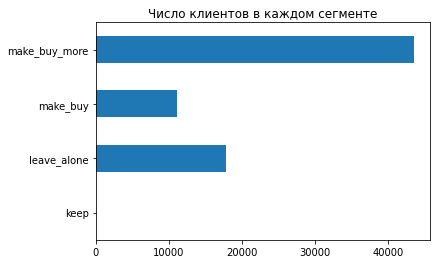

In [176]:
rfm.groupby('ranking').customer_unique_id.count().plot(kind='barh', title='Число клиентов в каждом сегменте', xlabel='')

**наибольшую выручку также приносят клиенты из сегмента make_buy_more. При этом клиенты сегмента keep, несмотря на частоту и свежесть покупок, принесли наименьшую выручку. Вероятно, это новые клиенты, которые пришли к магазин недавно.**

,ranking,Monetary
3,make_buy_more,194539.12
2,make_buy,97857.40
1,leave_alone,15535.91
0,keep,983.12


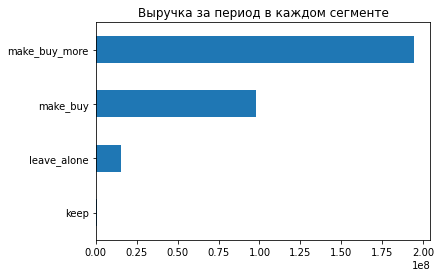

In [177]:
rfm.groupby('ranking').Monetary.sum().plot(kind='barh', title='Выручка за период в каждом сегменте', xlabel='')
round(rfm.groupby('ranking').Monetary.sum() / 1000,2).reset_index().sort_values(by='Monetary', ascending = False)

**Клиентов сегмента кип наименьшее число - 97 человек. При этом эти 97 человек формируют средний объем в 554 у.е.(а максимальный - 4,6 тыс у.е.) что является чеком выше, чем по другим сегментам, а также покупают чаще других. При этом клиенты сегментов make_buy и make_buy_more приносят большую выручку несмотря на редкость покупок.**

In [178]:
print('Monetary')
display(rfm.groupby('ranking').Monetary.describe())
print('Recency')
display(rfm.groupby('ranking').Recency.describe())
print('Frequency')
display(rfm.groupby('ranking').Frequency.describe())

Monetary


,count,mean,std,min,25%,50%,75%,max
ranking,,,,,,,,
keep,97.0,10135.296747,12427.956935,301.245,3140.865,6251.3057,13164.6308,97899.60
leave_alone,17861.0,869.822883,498.562904,0.000,437.900,801.3060,1240.0260,1921.32
make_buy,11097.0,8818.365434,20504.370165,1922.120,2644.920,3855.4610,7031.7100,581704.50
make_buy_more,43607.0,4461.190084,19135.710013,0.000,640.863,1468.5620,3294.8500,1300110.09


Recency


,count,mean,std,min,25%,50%,75%,max
ranking,,,,,,,,
keep,97.0,2353.360825,73.441188,2251.0,2292.0,2347.0,2388.0,2614.0
leave_alone,17861.0,2525.274397,44.597869,2454.0,2485.0,2524.0,2560.0,2614.0
make_buy,11097.0,2526.984590,44.686584,2454.0,2487.0,2525.0,2563.0,2614.0
make_buy_more,43607.0,2353.483363,59.166571,2249.0,2300.0,2357.0,2405.0,2453.0


Frequency


,count,mean,std,min,25%,50%,75%,max
ranking,,,,,,,,
keep,97.0,3.556701,1.290745,3.0,3.0,3.0,4.0,11.0
leave_alone,17861.0,1.011366,0.106005,1.0,1.0,1.0,1.0,2.0
make_buy,11097.0,1.035235,0.191101,1.0,1.0,1.0,1.0,3.0
make_buy_more,43607.0,1.026578,0.162410,1.0,1.0,1.0,1.0,3.0


> **Есть гипотеза, что мы рассматриваем магазин товаров не первой необходимости, а например - строительных материалов (т.к. в основном у клиентов случалась единственная закупка за долгое время, при этом на большие суммы. Если гипотеза верна, то проводить анализ необходимо под другим углом и с другими гипотезами, в связи с чем и выводы будут иные.**